## Identifying Opportunities to Reduce Car Crashes in Chicago

### Book 2: Explore the Dataset

### Objective

In this part of the project, we will explore the final dataset to achieve the following objectives:

1. Identify high-density areas of car crash in Chicago
2. Analyze control failures to identify opportunities for improvement
3. Check for trends in the time of crash to relocate resources appropriately

### Results

1. There is a higher density of accidents in the Downtown area of Chicago. It makes sense that the area with higher density of population would have the higher number of accidents.

2. The lack of traffic control devices and traffic ways not being divided has contributed the most to the number of car crashes in the city of Chicago. There is also a significant number of accidents that have occured at a traffic signal. External factors such as weather, road condition, visiblity, speed limit, etc. does not seem to have much impact to the overall incident. There were however some differences in the end result when the driver was performing certain maneuvers:

    - Turning, slow/stop in traffic - Injury & damage over 1500
    - Slow/stop in traffic, rear ended, pedestrian involved - Injury & damage under 1500
    - Slow/stop in traffic, rear ended, sideswipe same direction - No injury & damage over 1500
    - Slow/stop in traffic, rear ended, sideswipe same direction - No injury & damage under 1500

3. There was also a clear trend in the driver's age to the number of accidents casued. Accidents were more prominent with early drivers, showing a sharp increase from the age of 17 until 25. The accidents then showed a decreasing trend as the driver's aged showing less accidents with maturity and experience.

4. Most of the accidents seem to have occured between the hours of 3 to 5 in the afternoon. There was also an increasing number of accidents during the weekends. In terms of crash month, the crashes had an increasing trend as we moved towards the end of the year. April has the lowest number of accidents in Chicago.

### Data Exploration

In [1]:
# Import relevant packages

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Import the final dataset from previous section

df_final = pd.read_csv(r'Datasets/final_dataset.csv')

In [3]:
# Check the summary of the dataset

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687278 entries, 0 to 687277
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   MANEUVER                 687278 non-null  object 
 1   SEX                      687278 non-null  object 
 2   AGE                      687278 non-null  int64  
 3   DRIVER_VISION            687278 non-null  object 
 4   PHYSICAL_CONDITION       687278 non-null  object 
 5   POSTED_SPEED_LIMIT       687278 non-null  int64  
 6   TRAFFIC_CONTROL_DEVICE   687278 non-null  object 
 7   DEVICE_CONDITION         687278 non-null  object 
 8   WEATHER_CONDITION        687278 non-null  object 
 9   LIGHTING_CONDITION       687278 non-null  object 
 10  FIRST_CRASH_TYPE         687278 non-null  object 
 11  TRAFFICWAY_TYPE          687278 non-null  object 
 12  ALIGNMENT                687278 non-null  object 
 13  ROADWAY_SURFACE_COND     687278 non-null  object 
 14  ROAD

AGE and POSTED_SPEED_LIMIT are showing as integers. We want each of these varibles to have their own class so that we can assign importance to each of their unique values. We will change these into strings.

In [4]:
# Change the AGE values to string

df_final.AGE = df_final.AGE.map(lambda x : str(x))
df_final.POSTED_SPEED_LIMIT = df_final.POSTED_SPEED_LIMIT.map(lambda x: str(x))

In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687278 entries, 0 to 687277
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   MANEUVER                 687278 non-null  object 
 1   SEX                      687278 non-null  object 
 2   AGE                      687278 non-null  object 
 3   DRIVER_VISION            687278 non-null  object 
 4   PHYSICAL_CONDITION       687278 non-null  object 
 5   POSTED_SPEED_LIMIT       687278 non-null  object 
 6   TRAFFIC_CONTROL_DEVICE   687278 non-null  object 
 7   DEVICE_CONDITION         687278 non-null  object 
 8   WEATHER_CONDITION        687278 non-null  object 
 9   LIGHTING_CONDITION       687278 non-null  object 
 10  FIRST_CRASH_TYPE         687278 non-null  object 
 11  TRAFFICWAY_TYPE          687278 non-null  object 
 12  ALIGNMENT                687278 non-null  object 
 13  ROADWAY_SURFACE_COND     687278 non-null  object 
 14  ROAD

In [6]:
# Check all columns in the dataset

df_final.columns

Index(['MANEUVER', 'SEX', 'AGE', 'DRIVER_VISION', 'PHYSICAL_CONDITION',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'TARGET'],
      dtype='object')

### EDA 1: Identify High-Density Areas of Car Crashes in Chicago

We will use the Longitudes and Latitudes to find areas of accidents in Chicago.

We are going to use Python tool: Geopandas to plot the crashes on a map of Chicago. We can use a shape file to get the outline map of the streets of Chicago. This can be found in Chicago Data Portal. (https://data.cityofchicago.org/Transportation/Street-Center-Lines/6imu-meau)

We will then add a layer of geo-cordinates to plot all the accident prone areas in Chicago.

In [7]:
# Create a location dataframe

location = df_final[['TARGET', 'LONGITUDE', 'LATITUDE']].copy()

In order for the plot to work properly, we have to make sure that there are no zero values in our co-ordinates.

In [8]:
(location==0).sum()

TARGET          0
LONGITUDE    4669
LATITUDE     4669
dtype: int64

LONGITUDE and LATITUDE each have 4669 zero values. We need to remove them before plotting them.

In [9]:
# Remove zero values

location_clean = location[location.LONGITUDE != 0]

In [10]:
(location_clean==0).sum()

TARGET       0
LONGITUDE    0
LATITUDE     0
dtype: int64

### GeoPandas

In [11]:
# Import shape file for the streep map of Chicago
street_map = gpd.read_file(r'Datasets/Street Center Lines/geo_export_403d7ba8-bf6c-4814-b4d0-e9ad794558da.shx')

# Create the geometry for Long Lat
geometry = [Point(xy) for xy in zip(location_clean.LONGITUDE, location_clean.LATITUDE)] 

# Create a geo dataframe
geo_df = gpd.GeoDataFrame(location_clean, geometry=geometry)

While adding the layer of accidents, we will color code each of our four target variables.

- NO INJURY & DAMAGE OVER 1,500   - **Yellow** 
- NO INJURY & DAMAGE UNDER 1,500  - **Green**  
- INJURY & DAMAGE OVER 1,500      - **Red**    
- INJURY & DAMAGE UNDER 1,500     - **Blue**   

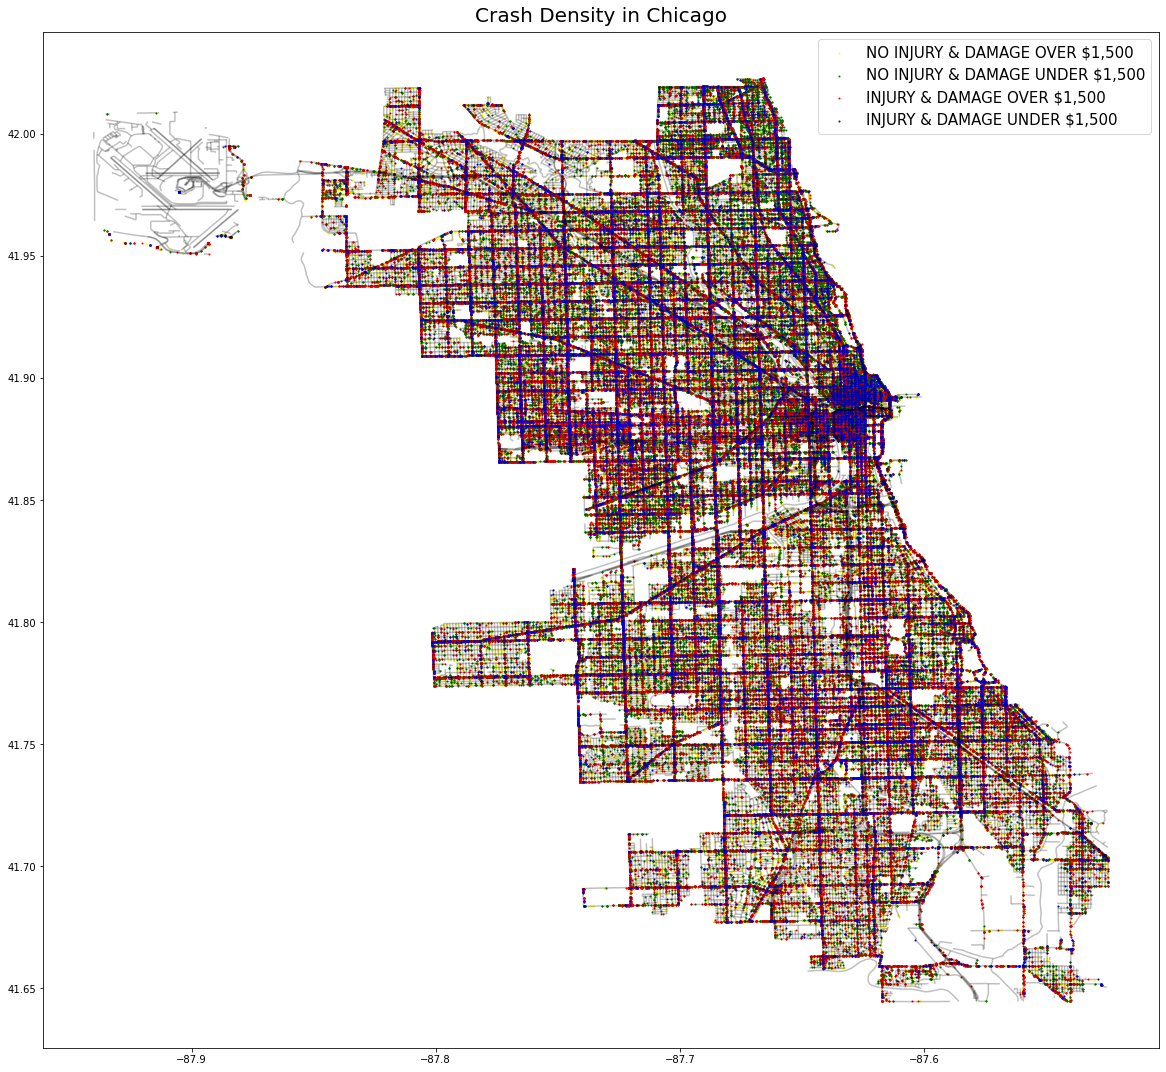

In [12]:
# Create a figure object 
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the street map
street_map.plot(ax=ax, alpha=0.25, color='black')

# Add markers for target variables
geo_df[geo_df['TARGET'] == 'NO INJURY & DAMAGE OVER $1,500'].plot(ax=ax, 
                                                                  markersize=1, 
                                                                  color='yellow', 
                                                                  marker='o',
                                                                  label='NO INJURY & DAMAGE OVER $1,500')
geo_df[geo_df['TARGET'] == 'NO INJURY & DAMAGE UNDER $1,500'].plot(ax=ax, 
                                                                   markersize=1, 
                                                                   color='green', 
                                                                   marker='o', 
                                                                   label='NO INJURY & DAMAGE UNDER $1,500')
geo_df[geo_df['TARGET'] == 'INJURY & DAMAGE OVER $1,500'].plot(ax=ax, 
                                                               markersize=1, 
                                                               color='red', 
                                                               marker='o', 
                                                               label='INJURY & DAMAGE OVER $1,500')
geo_df[geo_df['TARGET'] == 'INJURY & DAMAGE UNDER $1,500'].plot(ax=ax, 
                                                                markersize=1, 
                                                                color='blue', 
                                                                marker='o', 
                                                                label='INJURY & DAMAGE UNDER $1,500')
plt.legend(prop={'size':15}, loc=1)

plt.title('Crash Density in Chicago', fontsize=20, pad=10)

plt.savefig(r'Images/Street_Map.png', bbox_inches='tight');

From the map above we can make the following deductions:
- There is a high density of accidents in the Downtown area of Chicago. It is also mostly blue, which means that most of the accidents in that area have caused injury but with damages less than 1500 dollars. 
- It is important to note that there is high distribution of red markers too, which shows that there has been a lot of accidents with injury and damages over 1500 dollars. 
- The red and blue markers also form bold lines over major roadways showing that most of these accidents of this kind occur in those streets. 
- The yellow and green markers are spread all across the city showing accidents with no injury occuring almost everywhere. 

Let's dive into EDA 2 and 3 to investigate further.

### EDA 2: Analyze Control Failures to Identify Opportunities For Improvement

First, we will look at all the variables that are causing the accident. Later on, we will split between the four target variables, to explore different events.

For this part of the EDA, we will simply count the number of occurences for each event. The higher the count, the more critical the issue. It is safe to assume that the factors causing the most number of accidents are the ones that need to be fixed. 

We will plot this in a histogram to get a visual representation on what events are occuring the most.

In [13]:
df_final.columns

Index(['MANEUVER', 'SEX', 'AGE', 'DRIVER_VISION', 'PHYSICAL_CONDITION',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'TARGET'],
      dtype='object')

In [14]:
# Create a dataframe with all the variables to be investigated

df_factors = df_final[['MANEUVER', 'SEX', 'AGE', 'DRIVER_VISION', 'PHYSICAL_CONDITION',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'CRASH_TYPE', 'DAMAGE',]].copy()

In [15]:
df_factors.head()

MANEUVER SEX AGE DRIVER_VISION PHYSICAL_CONDITION POSTED_SPEED_LIMIT  \
0  STRAIGHT AHEAD   M  35  NOT OBSCURED             NORMAL                 30   
1  STRAIGHT AHEAD   M  25             0                  0                 30   
2  STRAIGHT AHEAD   M  37  NOT OBSCURED             NORMAL                 30   
3  STRAIGHT AHEAD   F  32  NOT OBSCURED             NORMAL                 25   
4  STRAIGHT AHEAD   F  37  NOT OBSCURED             NORMAL                 25   

  TRAFFIC_CONTROL_DEVICE DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS      NO CONTROLS             CLEAR   
1            NO CONTROLS      NO CONTROLS              RAIN   
2         OTHER CONTROLS      FUNCTIONING             CLEAR   
3         TRAFFIC SIGNAL      FUNCTIONING             CLEAR   
4         TRAFFIC SIGNAL      FUNCTIONING             CLEAR   

  LIGHTING_CONDITION          FIRST_CRASH_TYPE TRAFFICWAY_TYPE  \
0               DAWN        OTHER NONCOLLISION         DIVIDED   
1           DARKNESS      PARKED MOTOR VEHICLE     NOT DIVIDED   
2           DARKNESS  SIDESWIPE SAME DIRECTION         DIVIDED   
3           DAYLIGHT                     ANGLE     NOT DIVIDED   
4           DAYLIGHT                     ANGLE     NOT DIVIDED   

            ALIGNMENT ROADWAY_SURFACE_COND ROAD_DEFECT CRASH_TYPE  \
0  STRAIGHT AND LEVEL                  DRY  NO DEFECTS  NO INJURY   
1  STRAIGHT AND LEVEL                  WET  NO DEFECTS  NO INJURY   
2  STRAIGHT AND LEVEL                  DRY  NO DEFECTS  NO INJURY   
3  STRAIGHT AND LEVEL                  DRY  NO DEFECTS     INJURY   
4  STRAIGHT AND LEVEL                  DRY  NO DEFECTS     INJURY   

                DAMAGE  
0  DAMAGE UNDER $1,500  
1   DAMAGE OVER $1,500  
2  DAMAGE UNDER $1,500  
3   DAMAGE OVER $1,500  
4   DAMAGE OVER $1,500

We will create a dictionary to store the number of unique values present in each predictor.

In [16]:
# Put all value counts into a dictionary

count_dict = {}
for col in df_factors.columns: 
    count_dict[str(col)] = df_factors[col].value_counts()

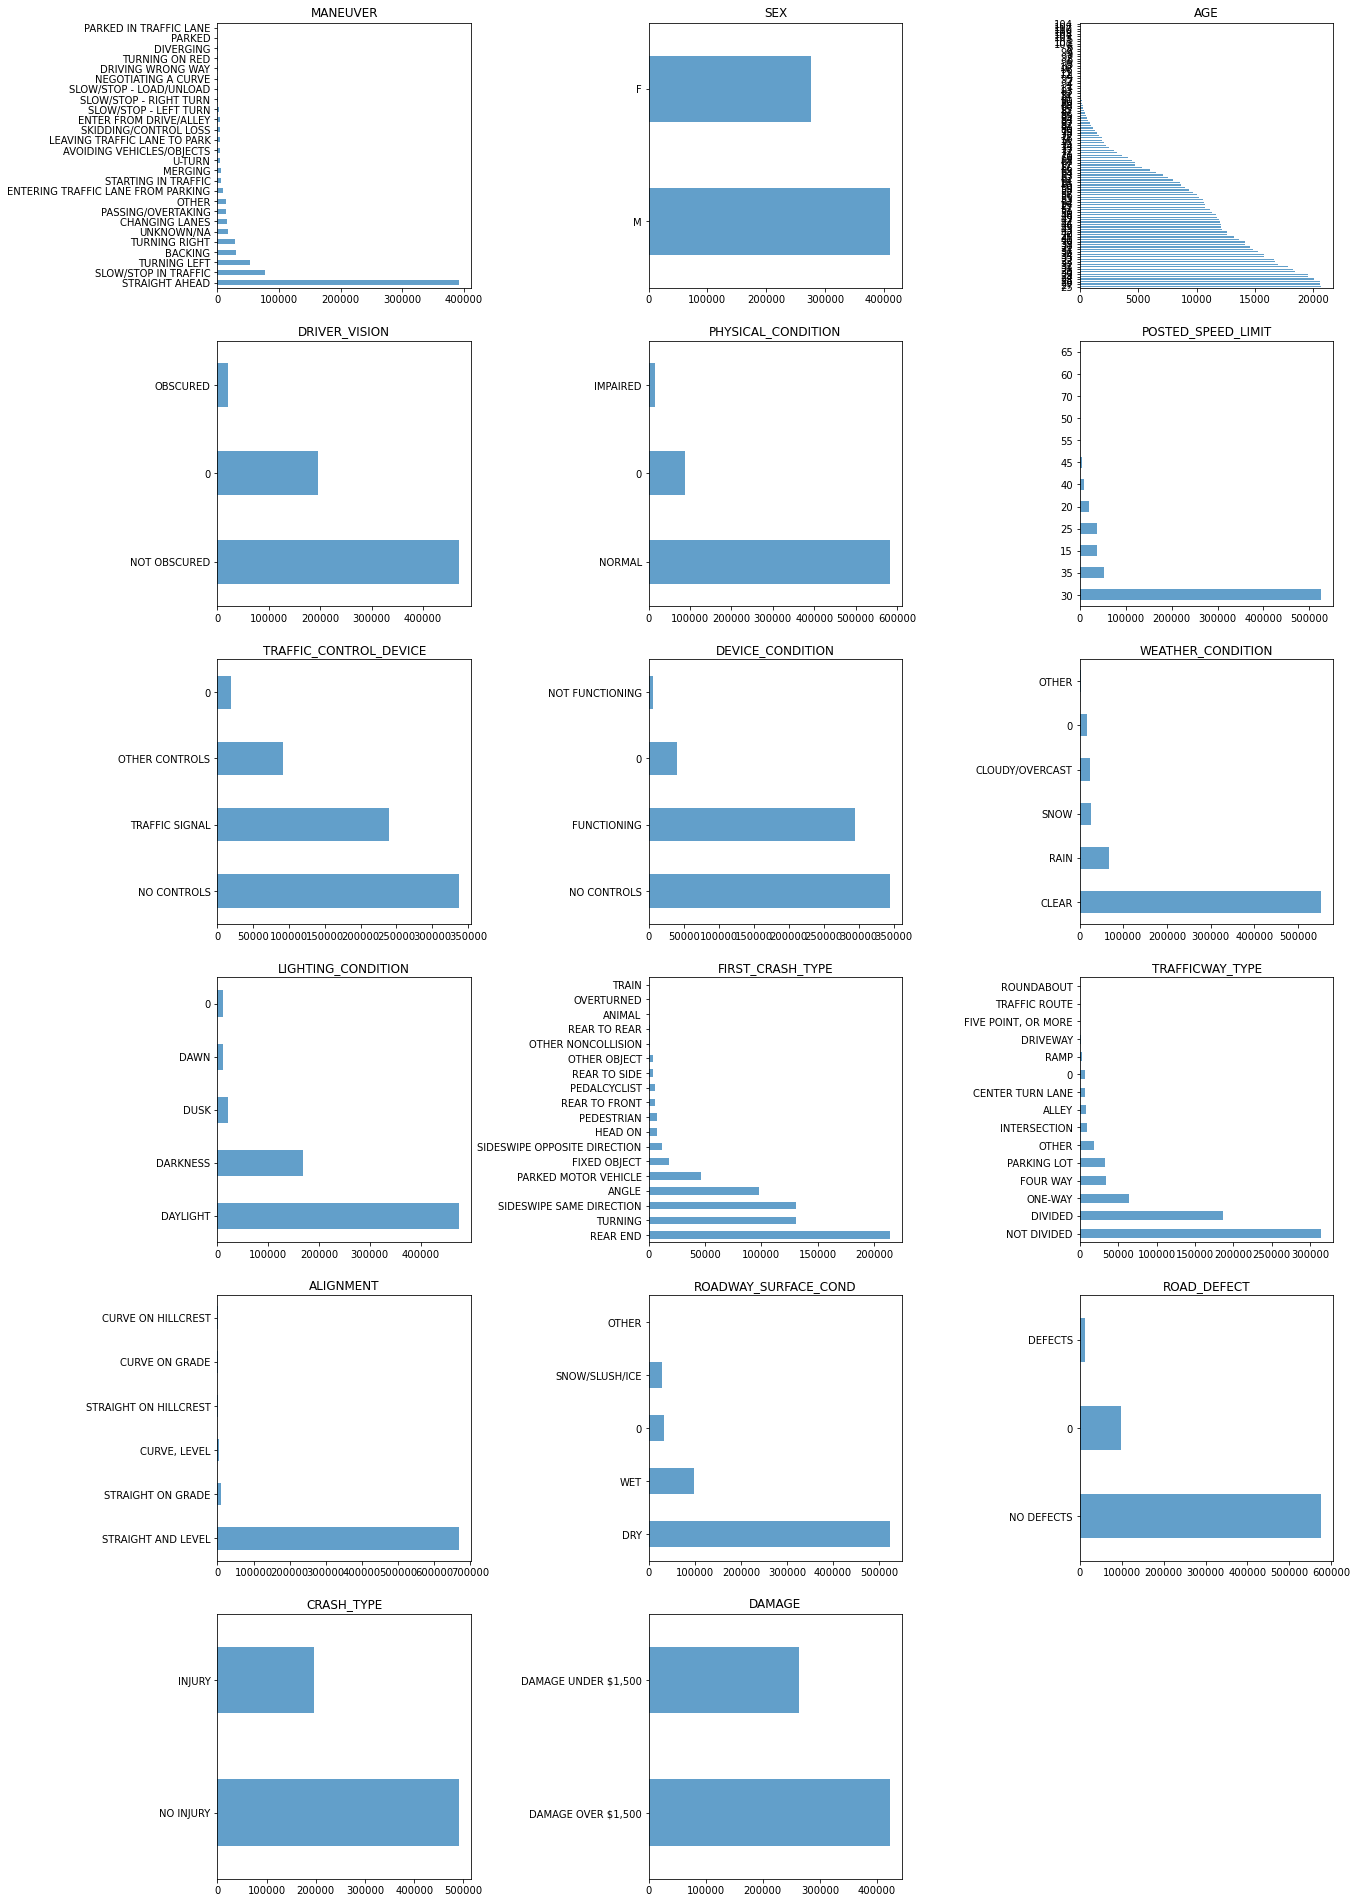

In [17]:
# Plot each columns in a horizontal barchart

plt.figure(figsize=(20,40))
plt.subplots_adjust(wspace=0.7)

for index, value in enumerate(count_dict):
    ax = plt.subplot(7, 3, index+1)
    chart = pd.DataFrame(count_dict[value])
    chart.plot(ax=ax, kind='barh', legend=False, alpha=0.7)
    ax.set_title(value)
    plt.savefig(r'Images/Predictor_Plots.png', bbox_inches='tight');

Looking at the variables with the largest count, we can make the following conclusions:

- Most of the accidents occured when one of the driver was travelling straight ahead.
- There seems to be a 60/40 distribution of accidents between Male to Female drivers.
- We will look at age disctribution separately.
- The TRAFFIC_CONTROL_DEVICE and DEVICE_CONDITION show that most of the accidents have occured where there was no controls present.
- The POSTED_SPEED_LIMIT was 30 when most of these accidents occured.
- Weather and Lighting condition does not seem to have much impact on the overall number of accidents.
- Most of the accidents occured due to a rear end collision followed by turning and sideswipe same direction.
- The trafficway type was also not divided for the most number of accidents.
- The road alignment and condition also seem to have no contribution to the accidents.
- There were more than double accidents that caused no injury but there were also more number of accidents that caused damage over 1500 dollars than damage less than 1500 dollars.

According to this, increasing the number of traffic control devices and creating divided trafficways can lead to an overall decrease in the number of accidents in the city. 

#### AGE

In [18]:
# Create a dataframe for AGE to sort the index values

df_age = pd.DataFrame(count_dict['AGE'])

In [19]:
df_age.head()

AGE
25  20676
27  20577
26  20525
28  20015
24  19569

In [20]:
# Since we had changed the age into strings earlier, we will have to change it back to int to sort properly

df_age.index = df_age.index.map(lambda x: int(x))

To plot the age distribution correctly, we will have to sort the dataframe in an ascending order.

In [21]:
# Sort index by age

df_age.sort_index(inplace=True)

In [22]:
df_age.head()

AGE
1   49
2   39
3   20
4   28
5    6

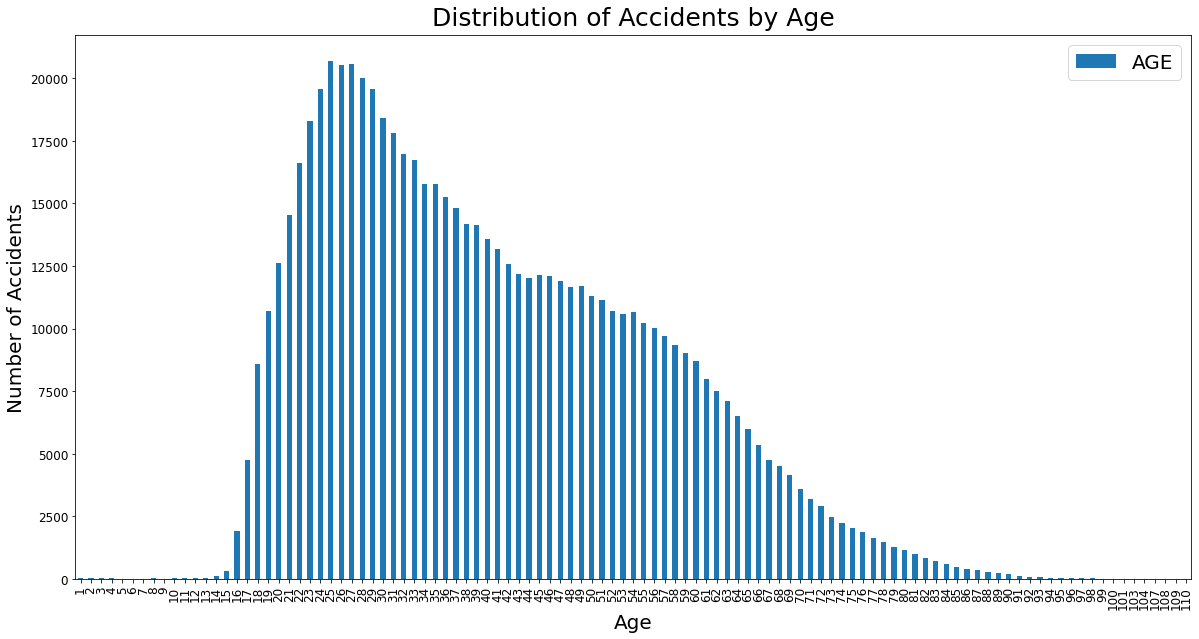

In [23]:
# Plot the distribution

df_age.plot(kind='bar', figsize=(20,10), fontsize=12)

plt.title('Distribution of Accidents by Age', fontsize=25, pad=10)
plt.xlabel('Age', fontsize=20)
plt.ylabel('Number of Accidents', fontsize=20)
plt.legend(fontsize=20)

plt.savefig(r'Images/Age_Distribution.png', bbox_inches='tight');

We can see that the number of accidents are more prominent with early drivers, starting from the age of 17 until 25. The accidents then show a decreasing trend as the driver's age and gather more experience.

### Accidents by Target Group

We will now look into the distribution of causes in each target variable.

In [24]:
# Slice the dataframe into all four target variables

df_red = df_final[df_final.TARGET == 'INJURY & DAMAGE OVER $1,500'].copy()
df_blue = df_final[df_final.TARGET == 'INJURY & DAMAGE UNDER $1,500'].copy()
df_yellow = df_final[df_final.TARGET == 'NO INJURY & DAMAGE OVER $1,500'].copy()
df_green = df_final[df_final.TARGET == 'NO INJURY & DAMAGE UNDER $1,500'].copy()

In [25]:
# Create dictionaries of value counts for all groups

count_dict_red = {}
for col in df_red.columns[:-10]:
    count_dict_red[str(col)] = df_red[col].value_counts()
    
count_dict_blue = {}
for col in df_blue.columns[:-10]:
    count_dict_blue[str(col)] = df_blue[col].value_counts()
    
count_dict_yellow = {}
for col in df_yellow.columns[:-10]:
    count_dict_yellow[str(col)] = df_yellow[col].value_counts()
    
count_dict_green = {}
for col in df_green.columns[:-10]:
    count_dict_green[str(col)] = df_green[col].value_counts()

Let's plot each subset.

#### 1. INJURY & DAMAGE OVER 1,500

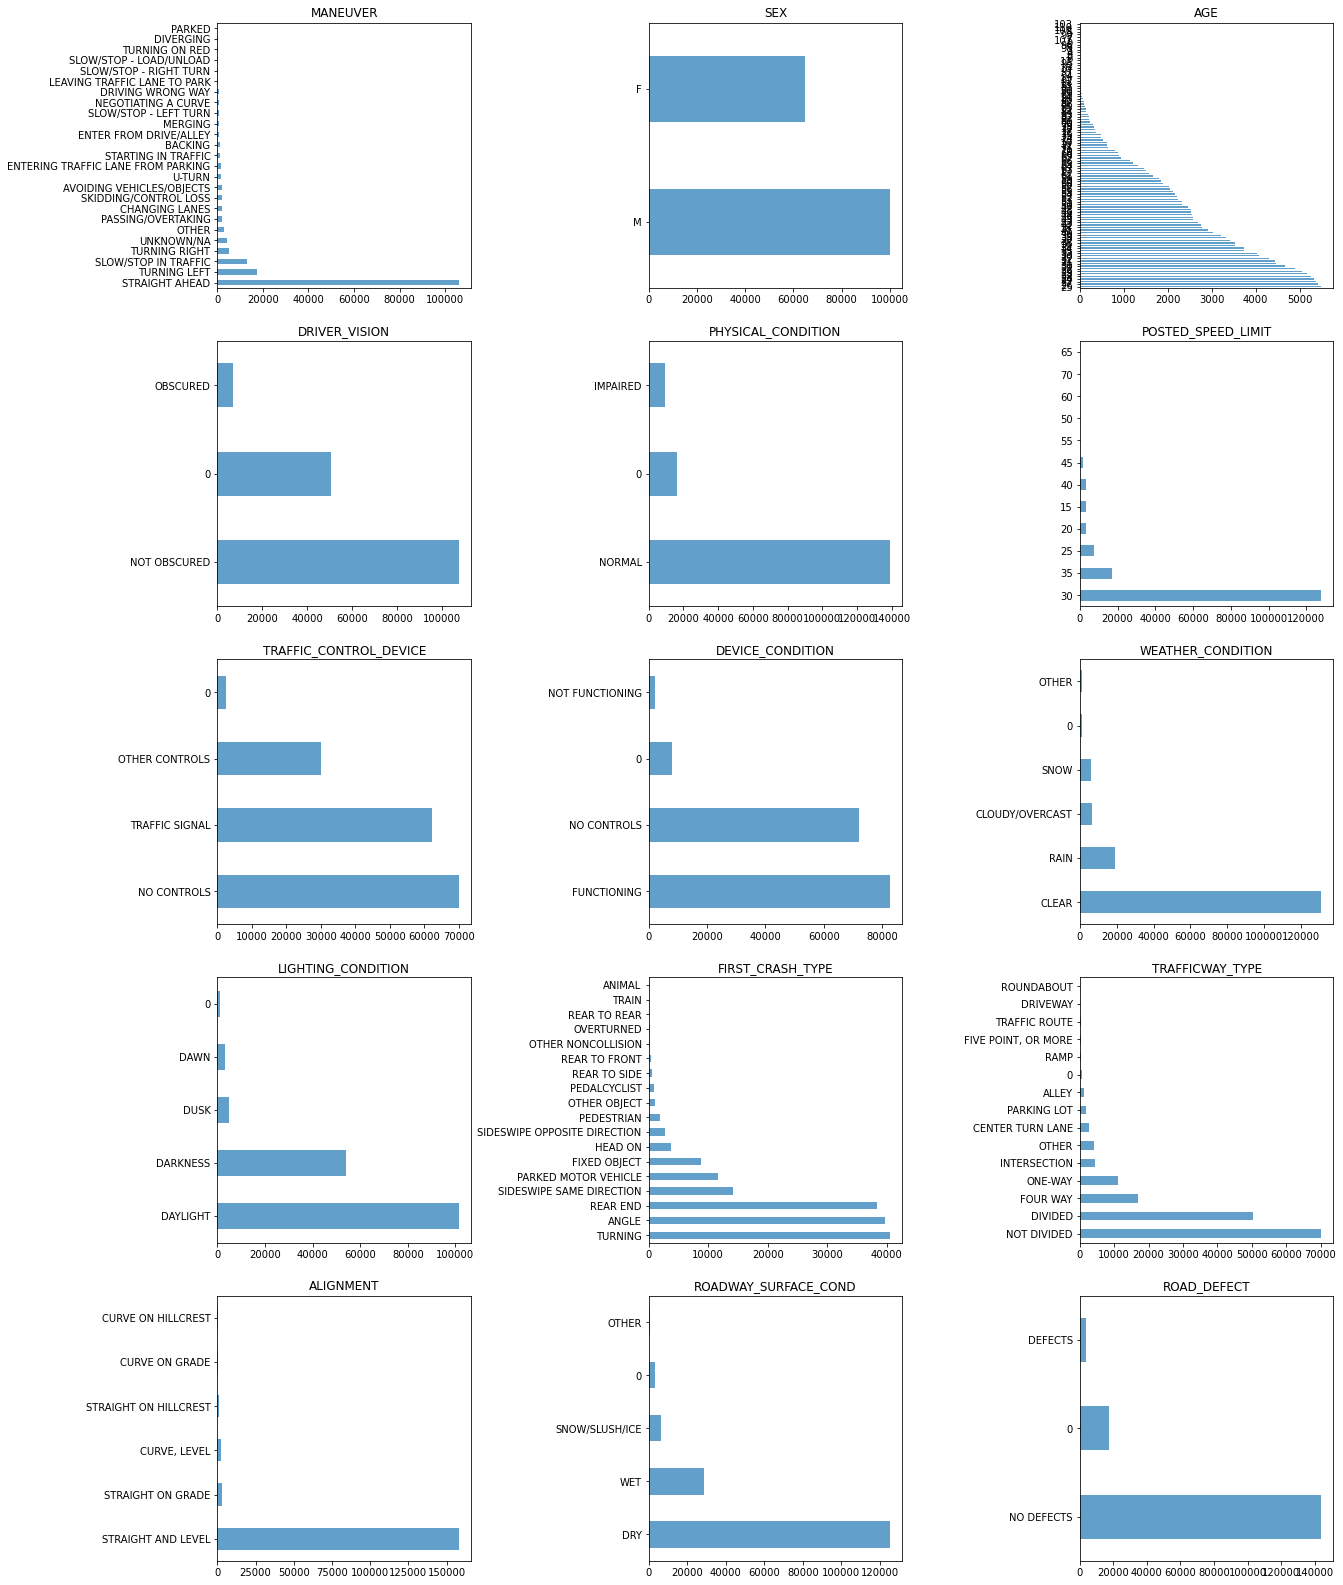

In [26]:
plt.figure(figsize=(20,40))
plt.subplots_adjust(wspace=0.7)

for index, value in enumerate(count_dict_red):
    ax = plt.subplot(7, 3, index+1)
    chart = pd.DataFrame(count_dict_red[value])
    chart.plot(ax=ax, kind='barh', legend=False, alpha=0.7)
    ax.set_title(value)
    plt.savefig(r'Images/Red_Plots.png', bbox_inches='tight');

The most number of accidents causing INJURY & DAMAGE OVER 1,500 seem to be occuring when:
- There are NO CONTROLS present or at a TRAFFIC SIGNAL.
- The vehicles seem to be either TURNING, at an ANGLE, or moving STRAIGH AHEAD, REAR ENDing the other vehicle.
- The TRAFFICWAY_TYPE was also NOT DIVIDED for the highest number of accidents. Although a lot of accidents also occured on DIVIDED roads.

#### 2. INJURY & DAMAGE UNDER 1,500

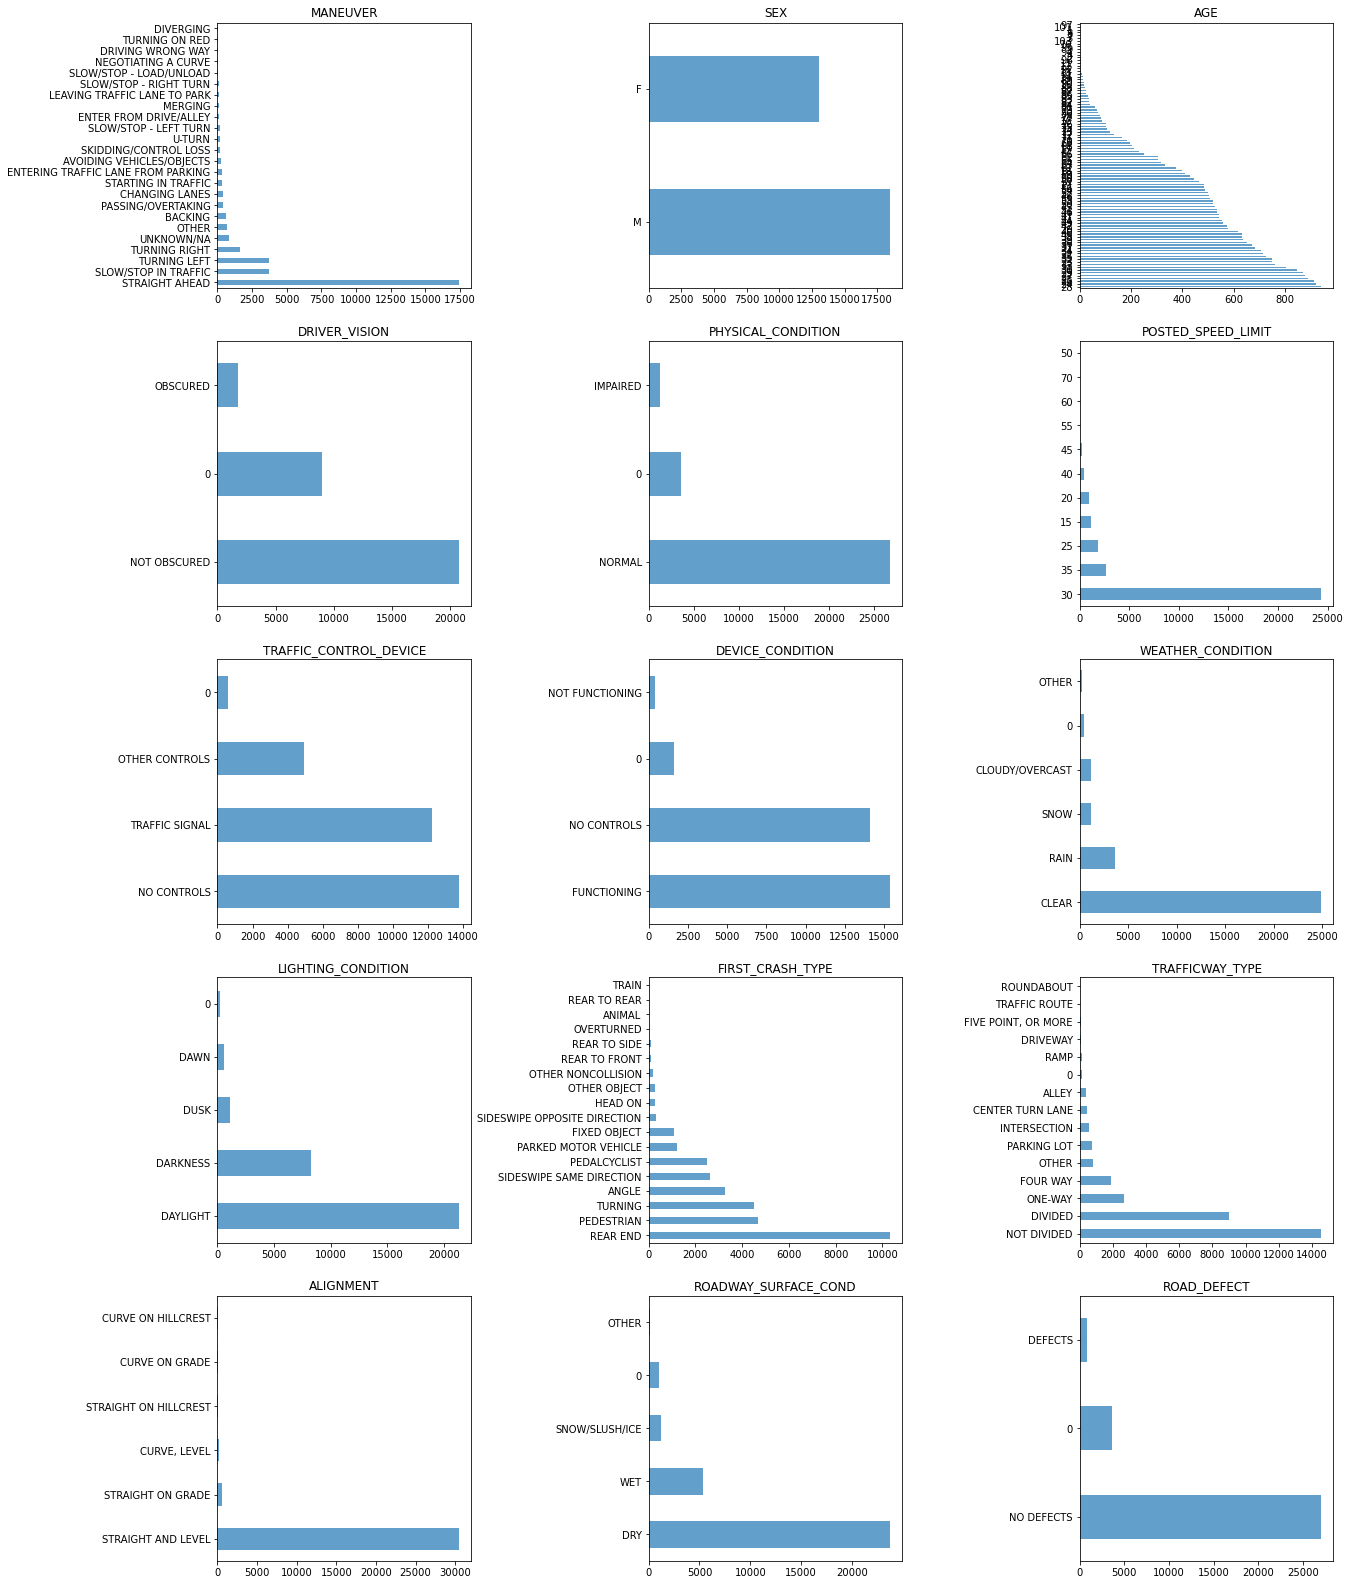

In [27]:
plt.figure(figsize=(20,40))
plt.subplots_adjust(wspace=0.7)

for index, value in enumerate(count_dict_blue):
    ax = plt.subplot(7, 3, index+1)
    chart = pd.DataFrame(count_dict_blue[value])
    chart.plot(ax=ax, kind='barh', legend=False, alpha=0.7)
    ax.set_title(value)
    plt.savefig(r'Images/Blue_Plots.png', bbox_inches='tight');

The results are similar to the red category, however there are some changes in the FIRST_CRASH_TYPE:
- The highest number of accidents with injury and damage less than 1500 seems to be due to REAR ENDing.
- The accidents also involve PEDESTRIANs when the vehicle was TURNING.
- All the others are remain the same.

#### 3. NO INJURY & DAMAGE OVER 1,500

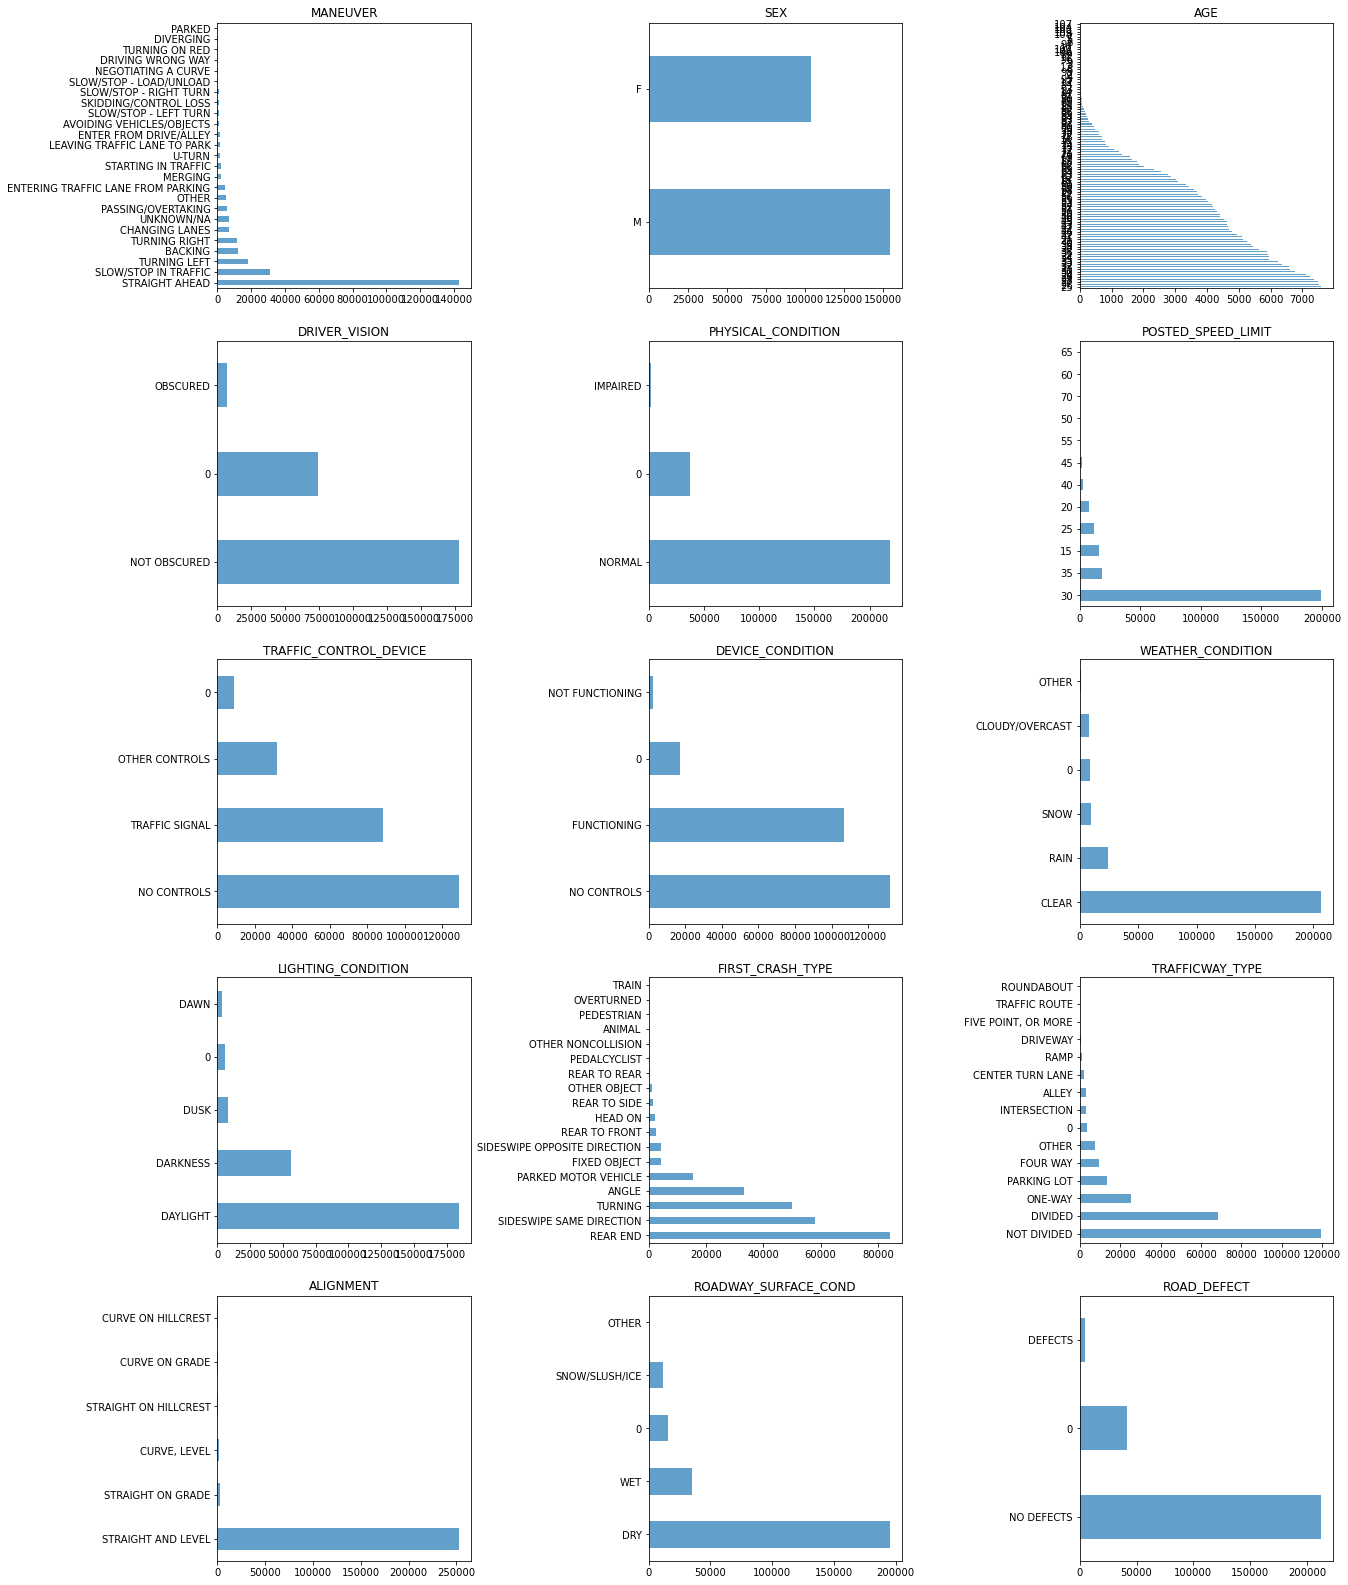

In [28]:
plt.figure(figsize=(20,40))
plt.subplots_adjust(wspace=0.7)

for index, value in enumerate(count_dict_yellow):
    ax = plt.subplot(7, 3, index+1)
    chart = pd.DataFrame(count_dict_yellow[value])
    chart.plot(ax=ax, kind='barh', legend=False, alpha=0.7)
    ax.set_title(value)
    plt.savefig(r'Images/Yellow_Plots.png', bbox_inches='tight');

Like the others, this category also shows similar characterstics. There are some differences in FIRST_CRASH_TYPE here also:
- REAR END leads the count followed by SIDESWIPE SAME DIRECTION and TURNING.
- Rest is all the same.

#### 4. NO INJURY & DAMAGE UNDER 1,500

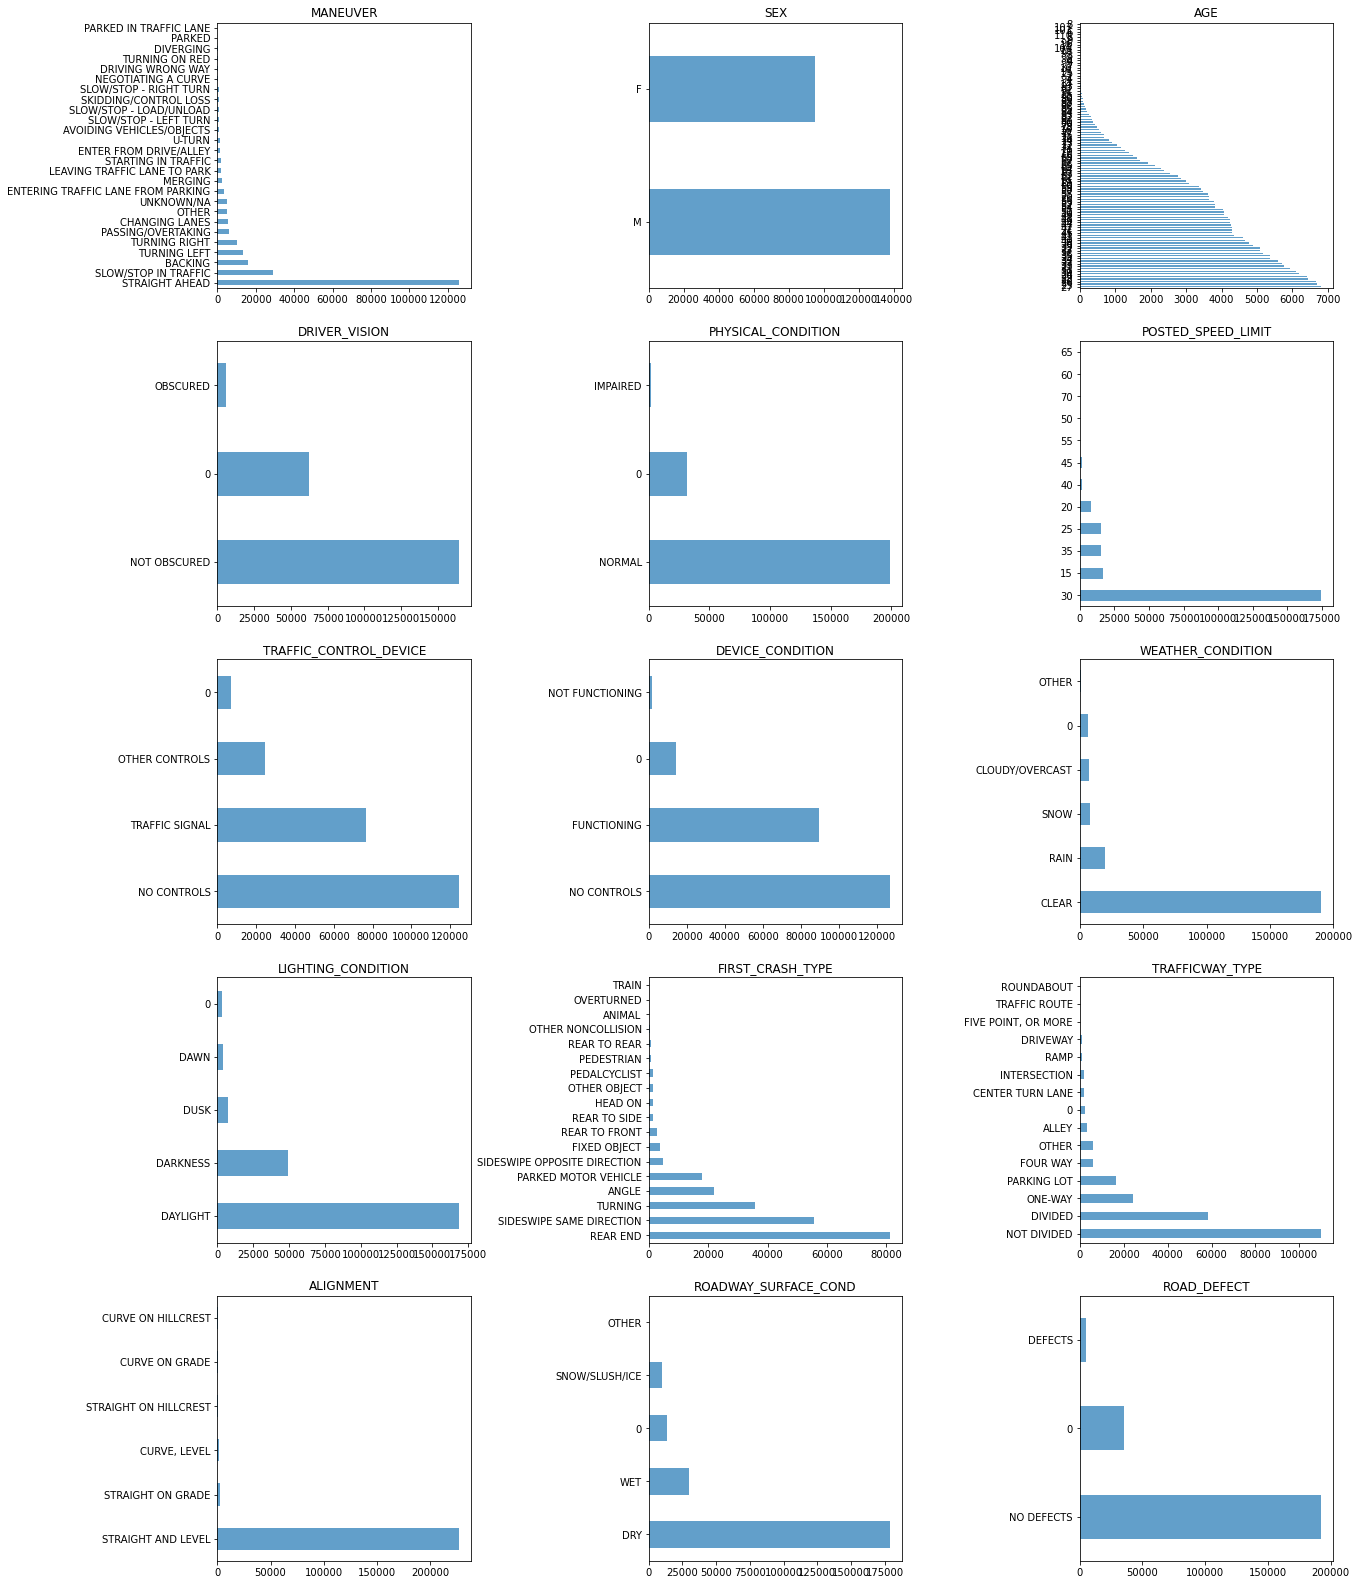

In [29]:
plt.figure(figsize=(20,40))
plt.subplots_adjust(wspace=0.7)

for index, value in enumerate(count_dict_green):
    ax = plt.subplot(7, 3, index+1)
    chart = pd.DataFrame(count_dict_green[value])
    chart.plot(ax=ax, kind='barh', legend=False, alpha=0.7)
    ax.set_title(value)
    plt.savefig(r'Images/Green_Plots.png', bbox_inches='tight');

This target variable shows almost identical characterstics to that of NO INJURY & DAMAGE OVER 1,500. Nothing relevant here to see.

Comparing all target variables individually there were some key characterstics that became apparent. 

- All these accidents seems to be occuring at a TRAFFIC SIGNAL or when there were NO SIGNALS present. 
- The conditions were near perfect and the speed limit was under 30 MPH. 
- The TRAFFICWAY_TYPE was also either NOT_DIVIDED or DIVIDED for all types of accidents. 
- The only difference is seen in MANEUVER and FIRST_CRASH_TYPE categories.

### EDA 3: Check for Trends in Time of Crash to Relocate Resources Appropriately

For this part of the EDA we will use all target variables.

In [30]:
df_time = df_final[['CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']].copy()

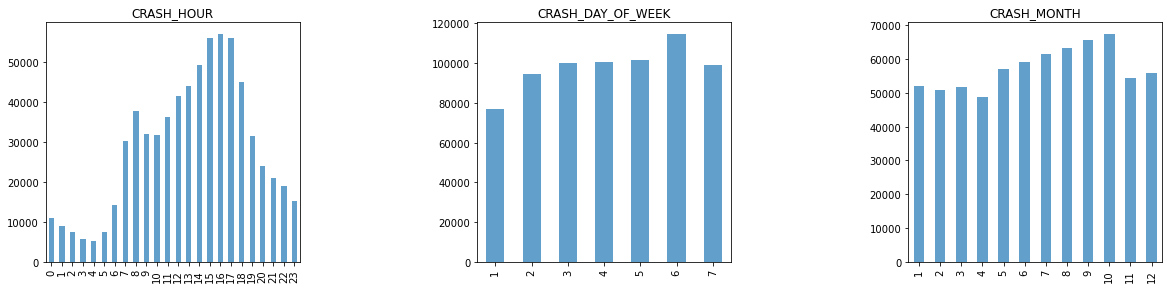

In [46]:
# Plot the graphs
plt.figure(figsize=(20,15))
plt.subplots_adjust(wspace=0.7)

for index, value in enumerate(df_time):
    ax = plt.subplot(3, 3, index+1)
    chart_2 = pd.DataFrame(df_time[value].value_counts()).sort_index()
    chart_2.plot(ax=ax, kind='bar', legend=False, alpha=0.7)
    ax.set_title(value)
    plt.savefig(r'Images/Time_of_crash.png', bbox_inches='tight');

From the above plots we can see the following trends in time of crash:
    
* Most of the accidents seem to happen between the hours of 3 to 5 in the afternoon. This might be due to peak rush hour traffic where every one is trying to get back home from work. When we connect this with the crash density map, we can deduce that most of the accidents in Chicago are occuring in the Downtown area during these hours where people are rushing to get home from work. There needs to be better traffic management at these times. We can recommend the city to have more facilitators in the Downtown area during these hours to help manage the flow of traffic and reduce the number of accidents.
* For day of the week, we see increased number of accidents during the weekends. However, they do not differ by much from other days. Looking at this we can say that there should be more focus on the crash hour than the crash day as the crashes dont differ much between the days.
* In terms of crash month, the crashes show an increasing trend as we move to the end of the year. April shows the lowest number of crashes. The last two months of the year also show breaking trends and a sharp decline in number of accidents in the city.

Now that we are done with our data exploration we can move on to create a classifier that will classify accidents into one of our four target variables. We will continue this in a separate Jupyter notebook.

In [32]:
# Export the final dataset

df_final.to_csv(r'Datasets/model_dataset.csv', index=False)